## Mounting drive:

In [3]:
## mounting google drive to get access to csv files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing libraries for analysis:

In [4]:
## importing the libraries for analysis
import pandas as pd
import numpy as np

## seaborn library with the additional rule to filter out the warnings
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## imporst matplotlib
import matplotlib.pylab as plt


## exporting/downloading df's 
from google.colab import files

## example how to download a df:
# df_name.to_csv("desired_name_of_csv_file.csv", index=False)
# files.download("desired_name_of_csv_file.csv")

## Importing csv's for analysis:

In [5]:
# orders_qu.csv
path = ('/content/drive/MyDrive/Colab Notebooks/Stas /orders_qu.csv')
orders_qu = pd.read_csv(path)

# orderlines_qu.csv
path = ('/content/drive/MyDrive/Colab Notebooks/Stas /orderlines_qu.csv')
orderlines_qu = pd.read_csv(path)

# products_cl.csv
path = ('/content/drive/MyDrive/Colab Notebooks/Stas /products_cl.csv')
products_cl = pd.read_csv(path)

## Cleaning and merging tables:

#### Deleting colum **state** from the table **orders_qu**




In [6]:
## deleting column 'state' in df 'orders_qu'
## 'state' can be deleted as the is only 'Completed'
orders_qu = orders_qu.drop(['state'], axis=1)

## deleting column 'product_id' in df 'orderlines_qu'
## 'product_id' can be deleted as it is an old identifier for each product
## axis=1 means that we are dropping a column. axis=0 referes to rows.
orderlines_qu = orderlines_qu.drop(['product_id'], axis=1)

#### Turing colums **create_date** in table **orders_qu** and **date** in table **orderlines_qu** into the date format


In [7]:
## df 'orders_qu' changing column 'created_date' from object to datetime
orders_qu["created_date"] = pd.to_datetime(orders_qu["created_date"])

## df 'orderlines_an' changing column 'date' from object to datetime
orderlines_qu["date"] = pd.to_datetime(orderlines_qu["date"])

#### Merging df **orderlines_qu** and df **products_cl**  INTO  new df **ol_p**
+ Both df's contain column sku. I'll use INNER merge (join) to combine the tables.

+ Reason for merging: To calculate the discouts. Those are ('unit_price' from df 'orderlines' - 'price' from df 'products').

In [8]:
ol_p = orderlines_qu.merge(products_cl, how='inner', on='sku')

#### Renaming columns to mitigate confusion with regards to the price colums in the merged df **orderlines_qu** and **products_cl**.

+ column **date** from df **orderlines_qu** >>> **ol_date**
+ column **unit_price** from df **orderlines_qu** >>> **ol_price**
+ column **price** from df **products_cl** >>> **p_price**

In [9]:
ol_p = ol_p.rename(columns={'date': 'ol_date', 'unit_price': 'ol_price', 'price':'p_price'})

## Calculating the discount:
Discount is the difference between the product price **p_price** and the unit price from orderlines, which is here **ol_price**.

### dicount = p_price - ol_price

With other words we build a difference between the actual product price and what the customer paid for it. 

*Example:* 
+ If our regular product price is 20€ but in the df of orderlines we registered that the customer paid 15€ for this product then the discount is 5€ (20 - 15 = 5).

+ Since the product price in the orderlines (now: ol_price) is:
* the unitary price (in euros) of each product at the moment of placing that order. 


In [10]:
## creating a new column called 'discount'
## puting the difference between 'p_price' and 'ol_price' into it
## rounding the result to 2 decimal points
ol_p['discount'] = (ol_p['p_price'] - ol_p['ol_price']).round(2)

## Calculaing **discount_total** and **price_total** (revenue)
+ The colums will be calculated by multiplying **product_quantity** with each: **ol_price** and **discount**.
+ These two columns will be added to the df **ol_p_an**

In [11]:
## calclulating and a adding new colum 'discount_total'
ol_p['discount_total'] = (ol_p['product_quantity'] * ol_p['discount']).round(2)

## calclulating and a adding new colum 'price_total'
ol_p['price_total'] = (ol_p['product_quantity'] * ol_p['ol_price']).round(2)

### Creating new column **discount_cat** aka discount category for characterization of discounts:
+ Just to mark all the records that have discount or not
+ Categories:
  + **yes** : discount if offered (discount_total > 0)
  + **no** : discount is not offered (discount_total == 0)
  + **negative** : discount has a negative value (discount_total < 0)

In [12]:
## Creating a new column 'discount_cat' aka discount category
## use numPy library to fill the new column with NaN values
ol_p['discount_cat'] = np.nan

## Write in to the column discount_cat according to the discount total status
## LTP means: let them pay; This is where our discount is negative and 
## customers pay more than the regular product price
ol_p.loc[(ol_p['discount_total'] < -0.09) , 'discount_cat'] = 'LTP'
ol_p.loc[(ol_p['discount_total'] > 0.09) , 'discount_cat'] = 'yes'
ol_p.loc[ol_p['discount_total'].between(-0.09, 0.09, inclusive='neither') , 'discount_cat'] = 'no'


## How can all the products be devided into categories (pie chart): 
+ yes: discount offered
+ no: no discount offered 
+ negative: the customer pays more than the regular price 

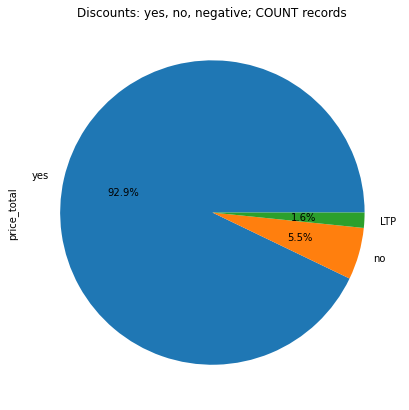

In [13]:
## by the number of records
(
    ol_p
    .groupby('discount_cat')['price_total']
    .count()
    .sort_values(ascending=False) 

    .plot.pie(figsize=(7, 7), autopct='%1.1f%%', title='Discounts: yes, no, negative; COUNT records')
);

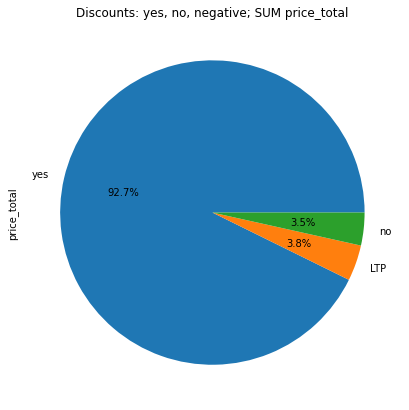

In [14]:
## by the revenue
(
    ol_p
    .groupby('discount_cat')['price_total']
    .sum()
    .sort_values(ascending=False) 

    .plot.pie(figsize=(7, 7), autopct='%1.1f%%', title='Discounts: yes, no, negative; SUM price_total')
);

## Which are the types that make 80% of the revenue?
+ All the products in the dataframe are assigned to a particular type (column **type** from the table **products**)

### What is the revenue for the whole period of the data?
+ 7971620.17 €
+ Puting the calculated value into variable for further calculation.

In [15]:
## revenue for the whole period we have data from
revenue_all = ol_p.price_total.sum().round(2)
print(f'Revenue for the whole data period is: {revenue_all} €.')

Revenue for the whole data period is: 7971620.17 €.


### What is the revenue for the whole period of the data separated by year and month?
+ The data here was reduced to the records where **discount_total >= 0**
+ With other words where discount is either 0 or positive

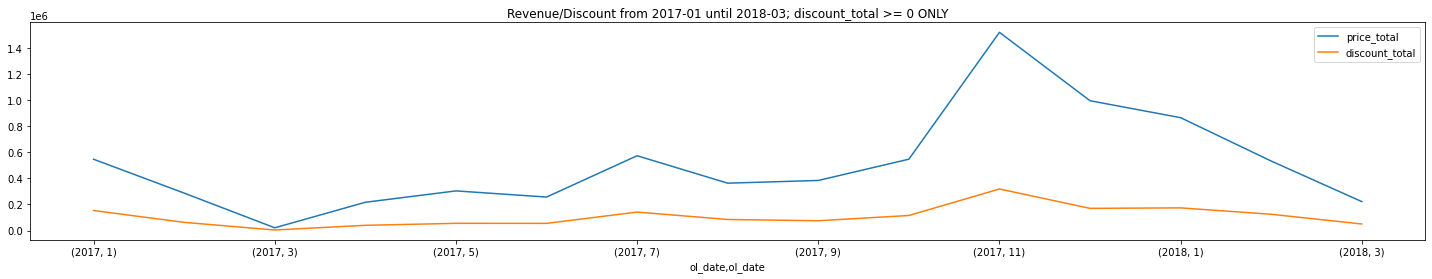

In [16]:
(
    ol_p
    ## records with discounts >=0 ONLY
    .loc[ol_p.discount_total >=0]
    .groupby(
        [
        ol_p['ol_date'].dt.year,
        ol_p['ol_date'].dt.month, 
        #ol_p['ol_date'].dt.month_name()
        ])['price_total', 'discount_total']
    .sum()
    .plot(figsize=(25, 4), x_compat=True, title='Revenue/Discount from 2017-01 until 2018-03; discount_total >= 0 ONLY')
);

# What do individual types mean?
### Add new column for **type_name**


In [17]:
## creates a new colum 'type_name' and fills is with NaN values
ol_p['type_name'] = np.nan

# How many individual types do we offer?
+ There are **117** types in our sortiment.

In [18]:
## creating a list with unique values out of colum 'type'
## calculating the length of the list
len(ol_p['type'].unique())
ol_p['type'].unique()

array(['12755395', '5720', '13005399', '1298', '11905404', '5384', '1387',
       '12175397', '5398', '1296', '13615399', '13835403', '13855401',
       '10230', '12655397', '14305406', '1405', '101781405', '1392',
       '1433', '1515', '12995397', '1230', '11865403', '57445397', '1424',
       '1216', '11935397', '12645406', '12575403', '12215397', '1325',
       '2434', '5,49E+11', '1364', '1375', '1276', '1334', '42945397',
       '1229', nan, '5407', '21485407', '12355400', '85651716', '5395',
       '85641716', '2449', '1231', '4259', '14365395', '24215399',
       '12585395', '13555403', '5405', '8696', '42931714', '2425',
       '12635403', '1,44E+11', '10142', '12085400', '14035403', '1282',
       '51871714', '5403', '9094', '15435404', '11821715', '24821716',
       '54085407', '1404', '51601716', '12141714', '54864259', '24861714',
       '20642062', '24895185', '5404', '13955395', '1280', '51861714',
       '24811716', '12285400', '13621714', '1416', '5,43E+15', '5401',
  

# Find the types that bring the most money for the company according to the 80 rule:

+ With other words: we want to find 20% types that bring 80% revenue and focus our analysis on those.

#### From the dataframe **ol_p**, extract all the types and their individual revenues:

In [19]:
revenue_all_types = (
    ## take the data frame ol_p
    ol_p
    ## group by type and pick the 'price_total'
    .groupby('type')['price_total']
    ## calculate the sum of all total prices for each type
    .sum()
    ## sort values from highest to lowest 
    .sort_values(ascending=False)
)
#type(revenue_all_types)

### Turn **revenue_all_types** series into a dataframe for further calculation:

In [20]:
revenue_all_types_df = revenue_all_types.to_frame().reset_index()
type(revenue_all_types_df)

pandas.core.frame.DataFrame

# Extracting a list of relevant types:
+ Find all types that bring 80% revenue

In [21]:
## initialise a variable to summarise all the revenue parts
revenue_80 = 0

## create an empty list to append all the types that are relevant for 20/80 rule
## Question: What are 20% of the types that bring 80% of the revenue?
list_types = []

## initialsing the counter to go through the each cell of the column
i = 0

## using a while loop with the condition that if revenue_80 is smaller than
## 80% of the revenue for the whole year we summarise the individual yearly
## revenues for each type
## the type that fits this codition we put in the list
## this list is relevant for us since it will contain all the  revenue relevant
## types 


while revenue_80 < revenue_all*0.80:
  revenue_80 += revenue_all_types_df.price_total[i]
  ## create a list with relevant types
  list_types.append(revenue_all_types_df.type[i])
  i += 1

## now list_types contains all the relevant categories

In [22]:
len(list_types)

24

# How many types which bring 80% of the overall revenue are there? 
+ 24 types

In [23]:
print(f'There are {len(list_types)} types that are responsible for 80% of the overall revenue.')

There are 24 types that are responsible for 80% of the overall revenue.


# Let's categorize the types (**!ASSUMPTION!** type column already splits the products corectly):

## To split into categories we could look into the types manualy
+ Build a filter and search for types one by one starting with the most vailuble one

In [24]:
#list_types

# **FILTER + WRITER**

In [25]:
## Filtering by type from the list 'list_types' one by one manualy 
## Show me the name, description, type_name and price_total for the picked 'type'

# ol_p.loc[ol_p['type_name']=='adapter', ['name','desc','type_name', 'type', 'price_total']].sample(5)

In [26]:
## renaming the columns with the applied filter, which filters according to type
## all types were taken from the list 'list_types'
#------------------------------------------------------------------------
#------------------------------------------------------------------------
ol_p.loc[ol_p['type']=='12995397','type_name'] = 'drive_dock_storage'
ol_p.loc[ol_p['type']=='12585395','type_name'] = 'adapter'
ol_p.loc[ol_p['type']=='11865403','type_name'] = 'cases_iphone'
ol_p.loc[ol_p['type']=='1714','type_name'] = 'iPad'
ol_p.loc[ol_p['type']=='5398','type_name'] = 'speaker'
ol_p.loc[ol_p['type']=='24895185','type_name'] = 'apple_watch'
ol_p.loc[ol_p['type']=='1433','type_name'] = 'SSD_kit_storage'
ol_p.loc[ol_p['type']=='106431714','type_name'] = 'iPad_pro'
ol_p.loc[ol_p['type']=='1405','type_name'] = 'tablets'
ol_p.loc[ol_p['type']=='5384','type_name'] = 'headset'
ol_p.loc[ol_p['type']=='11905404','type_name'] = 'sensor_electronics'
ol_p.loc[ol_p['type']=='21561716','type_name'] = 'iPhone_6'
ol_p.loc[ol_p['type']=='85651716','type_name'] = 'iPhone_7+'
ol_p.loc[ol_p['type']=='113281716','type_name'] = 'iPhone_8+'
ol_p.loc[ol_p['type']=='85641716','type_name'] = 'iPhone_7'
ol_p.loc[ol_p['type']=='113291716','type_name'] = 'iPhone_8'
ol_p.loc[ol_p['type']=='1298','type_name'] = 'opened_products_mix'
ol_p.loc[ol_p['type']=='11935397','type_name'] = 'ext_HD_storage'
ol_p.loc[ol_p['type']=='1296','type_name'] = 'monitors'
ol_p.loc[ol_p['type']=='12175397','type_name'] = 'server'
ol_p.loc[ol_p['type']=='12215397','type_name'] = 'SSD_storage'
ol_p.loc[ol_p['type']=='1364','type_name'] = 'RAM_mac_storage'
ol_p.loc[ol_p['type']=='12655397','type_name'] = 'NAS_HD_storage'
ol_p.loc[ol_p['type']=='51601716','type_name'] = 'iPhone_SE'

--- 
---

# Inspecting the created type names and theirs revenue share with **pie chart**:
+ Shall we exclude negative discount?

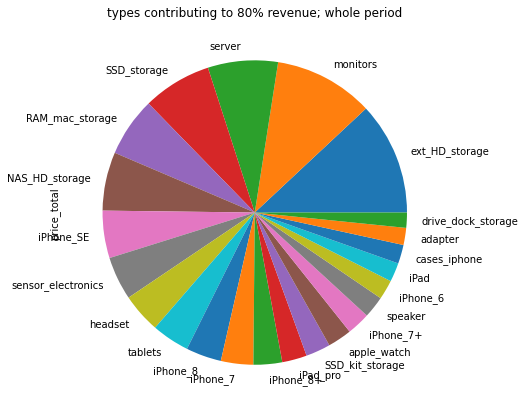

In [27]:
## pie chart represents how indivisual types split the revenue
## allows to see the best contributer 
(
    ol_p
    .loc[ol_p['type'].isin(list_types)]
    .groupby('type_name')['price_total']
    .sum()
    .sort_values(ascending=False) 

    .plot.pie(figsize=(7, 7), title='types contributing to 80% revenue; whole period')
);

## for percentage add to 'title':   autopct='%1.1f%%'

# Adding column **category** to categorize products from the list **list_types** 
+ filling the column **category** with NaN values

In [28]:
## creates a new colum 'category' and fills is with NaN values
ol_p['category'] = np.nan

### Putting apple products into one category **apple_products**:

In [29]:
## puting all apple products into one category
## you need the first conditon .isin(list_types); otherwise this doesn't work
ol_p.loc[(ol_p['type'].isin(list_types)) & (ol_p['type_name'].str.contains('iPhone|iPad|apple|iMac')),'category'] = 'apple_products'

### Putting all the storage related products into the colum **storage**:

In [30]:
## puting all storage related products into one category 'storage'
## you need the first conditon .isin(list_types_20); otherwise this doesn't work
ol_p.loc[(ol_p['type'].isin(list_types)) & (ol_p['type_name'].str.contains('storage')),'category'] = 'storage'

### Putting types **sensor_electronics**, **cases_iphone** and **adapter** to one category **accessories**

In [31]:
## Combine categories 'sensor_electronics' and 'cases_iphone' to one category 'accessories'
ol_p.loc[(ol_p['type'].isin(list_types)) & (ol_p['type_name'].str.contains('sensor|cases|adapter')),'category'] = 'accessories'

### Putting all the rest of the types into the column **category** the way they are in the column **type_name**

In [32]:
## opened_products_mix >> category 'opened_products_mix'
ol_p.loc[(ol_p['type'].isin(list_types)) & (ol_p['type_name'].str.contains('opened')),'category'] = 'opened_products_mix'
## headset >> category 'headset'
ol_p.loc[(ol_p['type'].isin(list_types)) & (ol_p['type_name'].str.contains('headset')),'category'] = 'headset'
## speakers >> category 'speakers'
ol_p.loc[(ol_p['type'].isin(list_types)) & (ol_p['type_name'].str.contains('speaker')),'category'] = 'speaker'
## monitors >> category 'monitors'
ol_p.loc[(ol_p['type'].isin(list_types)) & (ol_p['type_name'].str.contains('monitors')),'category'] = 'monitors'
## tablets >> category 'tablets'
ol_p.loc[(ol_p['type'].isin(list_types)) & (ol_p['type_name'].str.contains('tablets')),'category'] = 'tablets'
## server >> category 'server'
ol_p.loc[(ol_p['type'].isin(list_types)) & (ol_p['type_name'].str.contains('server')),'category'] = 'server'


# Inspecting the created categories and theirs revenue share with **pie chart**:
+ + Shall we exclude negative discount?

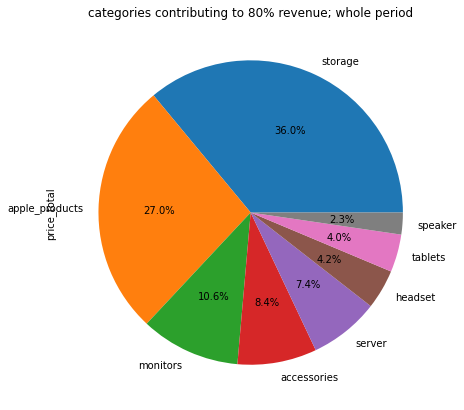

In [33]:
## pie chart represents how indivisual categories split the revenue
## allows to see the best contributer 
(
    ol_p
    .loc[ol_p['type'].isin(list_types)]
    .groupby('category')['price_total']
    .sum()
    .sort_values(ascending=False) 

    .plot.pie(figsize=(7, 7), autopct='%1.1f%%', title='categories contributing to 80% revenue; whole period')
);

# Conserns:
+ What should we do with **negative** discounts?

---
---
---
# Downloading the current dataframe:

In [ ]:
ol_p.to_csv("ol_p_02.csv", index=False)
files.download("ol_p_02.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
ol_p.sample(20
            )

,id,id_order,product_quantity,sku,ol_price,ol_date,name,desc,p_price,in_stock,type,discount,discount_total,price_total,discount_cat,type_name,category
39574,1596179,504339,1,MAT0007,99.00,2018-02-02 11:57:57,Matias Bluetooth keyboard Aluminum + Spanish n...,Aluminum Bluetooth keypad manages 4 devices si...,119.99,1,13855401,20.99,20.99,99.00,yes,NaN,NaN
28138,1161113,315667,1,DLL0035,289.99,2017-01-27 10:39:22,"Dell U2415 Monitor 24 ""FHD",FHD 24-inch monitor with multiple ports for Ma...,371.99,1,1296,82.00,82.00,289.99,yes,monitors,monitors
43697,1374329,410652,1,TUC0229,12.99,2017-10-09 21:03:36,Housing Flex Elektro Tucano iPhone 6 / 6S Clea...,Cover for iPhone 6 / 6S.,16.90,0,11865403,3.91,3.91,12.99,yes,cases_iphone,accessories
46274,1524423,475998,1,APP2497,358.38,2017-12-29 10:50:37,Apple Watch GPS 38mm Case Series 3 Aluminum Si...,38mm Apple Watch series 3 with GPS altimeter a...,369.00,1,24885185,10.62,10.62,358.38,yes,NaN,NaN
7092,1260414,361699,1,PIE0028,14.99,2017-06-02 14:35:33,internal battery for iPhone 5,Replacement AC Adapter for Apple iPhone 5.,14.95,1,21485407,-0.04,-0.04,14.99,no,NaN,NaN
42655,1293078,377579,1,APP2446,389.00,2017-07-14 17:16:08,Apple iPhone 6 32GB Space Gray,New iPhone 6 32GB Space Gray,449.33,0,21561716,60.33,60.33,389.00,yes,iPhone_6,apple_products
40844,1325899,393274,1,SSE0007,25.99,2017-08-28 08:25:31,Intelligent wireless thermometer Sen.se Thermo...,Bluetooth thermometer measures the temperature...,29.99,0,11905404,4.00,4.00,25.99,yes,sensor_electronics,accessories
42860,1594781,503752,1,APP2446,382.00,2018-02-01 13:38:41,Apple iPhone 6 32GB Space Gray,New iPhone 6 32GB Space Gray,449.33,0,21561716,67.33,67.33,382.00,yes,iPhone_6,apple_products
33044,1304092,382806,1,CAI0008,17.99,2017-07-27 13:28:51,Casetify Live Laugh Love Case iPhone 6 / 6S White,Casetify fashion sleeve for iPhone 6 / 6S.,39.95,0,11865403,21.96,21.96,17.99,yes,cases_iphone,accessories
31650,1357276,402390,1,DLL0030,414.99,2017-09-20 19:36:09,"Dell UltraSharp Monitor UP2516D 25 ""QHD 2 HDMI...",Monitor with slim frame premier technology hei...,527.99,1,1296,113.00,113.00,414.99,yes,monitors,monitors


In [35]:
ol_p.category.unique()

array([nan, 'accessories', 'headset', 'server', 'speaker', 'monitors',
       'storage', 'tablets', 'apple_products'], dtype=object)

In [73]:
ol_p_discounted = ol_p.loc[ol_p['discount_cat'] == 'yes', :].drop(columns=['desc','in_stock'])

In [74]:
ol_p_discounted

,id,id_order,product_quantity,sku,ol_price,ol_date,name,p_price,type,discount,discount_total,price_total,discount_cat,type_name,category
0,1119116,299545,1,OWC0100,47.49,2017-01-01 01:46:16,OWC In-line Digital Temperature Sensor Kit HDD...,60.99,12755395,13.50,13.50,47.49,yes,NaN,NaN
1,1120182,299404,1,OWC0100,47.49,2017-01-01 22:50:39,OWC In-line Digital Temperature Sensor Kit HDD...,60.99,12755395,13.50,13.50,47.49,yes,NaN,NaN
2,1121550,300650,1,OWC0100,49.99,2017-01-02 15:31:09,OWC In-line Digital Temperature Sensor Kit HDD...,60.99,12755395,11.00,11.00,49.99,yes,NaN,NaN
3,1121801,300760,1,OWC0100,49.99,2017-01-02 17:20:31,OWC In-line Digital Temperature Sensor Kit HDD...,60.99,12755395,11.00,11.00,49.99,yes,NaN,NaN
4,1124334,301975,1,OWC0100,49.99,2017-01-03 20:04:54,OWC In-line Digital Temperature Sensor Kit HDD...,60.99,12755395,11.00,11.00,49.99,yes,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54319,1647425,526066,1,WAC0254,83.99,2018-03-12 17:45:42,Education - Wacom Intuos Graphics Tablet S Blu...,99.00,1405,15.01,15.01,83.99,yes,tablets,tablets
54320,1647495,526093,1,WAC0252,83.99,2018-03-12 18:32:29,Education - Wacom Intuos Graphics Tablet S Blu...,99.00,1405,15.01,15.01,83.99,yes,tablets,tablets
54321,1648399,526440,1,PAC2235,878.18,2018-03-13 15:08:27,Synology DS218 + NAS Server | 6GB RAM | 16TB (...,1124.98,12175397,246.80,246.80,878.18,yes,server,server
54322,1648457,526512,1,DLK0044-A,84.32,2018-03-13 16:19:18,Open - D-Link DCS-5020L wireless surveillance ...,139.99,9094,55.67,55.67,84.32,yes,NaN,NaN


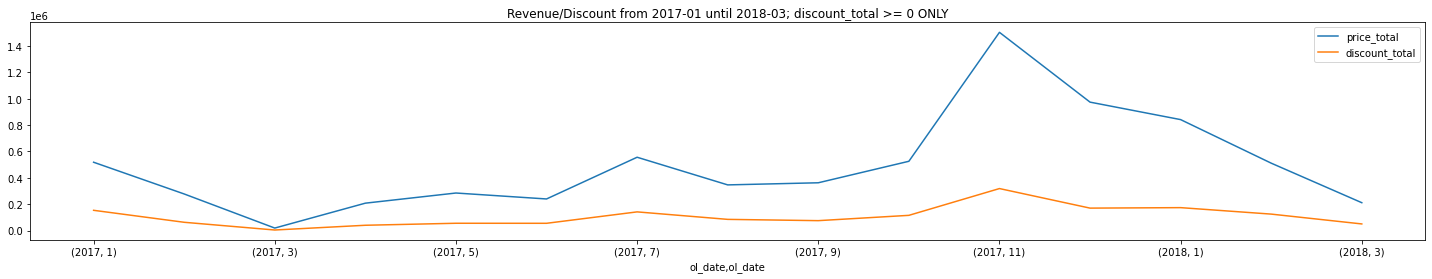

In [38]:
(
    ol_p_discounted
    ## records with discounts >=0 ONLY
    .loc[ol_p_discounted.discount_total >=0]
    .groupby(
        [
        ol_p_discounted['ol_date'].dt.year,
        ol_p_discounted['ol_date'].dt.month, 
        #ol_p['ol_date'].dt.month_name()
        ])['price_total', 'discount_total']
    .sum()
    .plot(figsize=(25, 4), x_compat=True, title='Revenue/Discount from 2017-01 until 2018-03; discount_total >= 0 ONLY')
);

In [75]:
ol_p_no_discounted = ol_p.loc[ol_p['discount_cat'] == 'no', :].drop(columns=['desc','in_stock'])

In [76]:
ol_p_no_discounted

,id,id_order,product_quantity,sku,ol_price,ol_date,name,p_price,type,discount,discount_total,price_total,discount_cat,type_name,category
347,1386749,416782,1,GRT0456,44.99,2017-10-24 15:45:52,Griffin iTrip Aux Lightning,44.99,13615399,0.0,0.0,44.99,no,NaN,NaN
369,1142621,307948,1,APP0023,59.00,2017-01-12 13:41:51,Apple Mac Keyboard Keypad Spanish,59.00,13855401,0.0,0.0,59.00,no,NaN,NaN
370,1144221,308676,1,APP0023,59.00,2017-01-13 11:43:31,Apple Mac Keyboard Keypad Spanish,59.00,13855401,0.0,0.0,59.00,no,NaN,NaN
371,1148628,310382,1,APP0023,59.00,2017-01-16 18:18:21,Apple Mac Keyboard Keypad Spanish,59.00,13855401,0.0,0.0,59.00,no,NaN,NaN
372,1149003,310724,1,APP0023,59.00,2017-01-16 23:10:15,Apple Mac Keyboard Keypad Spanish,59.00,13855401,0.0,0.0,59.00,no,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,1624417,516219,1,APP1788,59.00,2018-02-22 21:51:02,Apple Correa Rosa 38mm Sport Arena,59.00,2449,0.0,0.0,59.00,no,NaN,NaN
54255,1634938,520968,2,IFX0176,62.99,2018-03-04 19:05:31,Full iFixit iPhone Battery Kit Battery change 7,62.99,21485407,0.0,0.0,125.98,no,NaN,NaN
54277,1639515,522944,1,APP2103,59.00,2018-03-07 20:10:03,Apple Correa Sport 38mm Blue Haze,59.00,2449,0.0,0.0,59.00,no,NaN,NaN
54282,1639824,523077,1,WAC0251,99.00,2018-03-08 00:55:18,Wacom Intuos Graphics Tablet S Bluetooth Black,99.00,1405,0.0,0.0,99.00,no,tablets,tablets


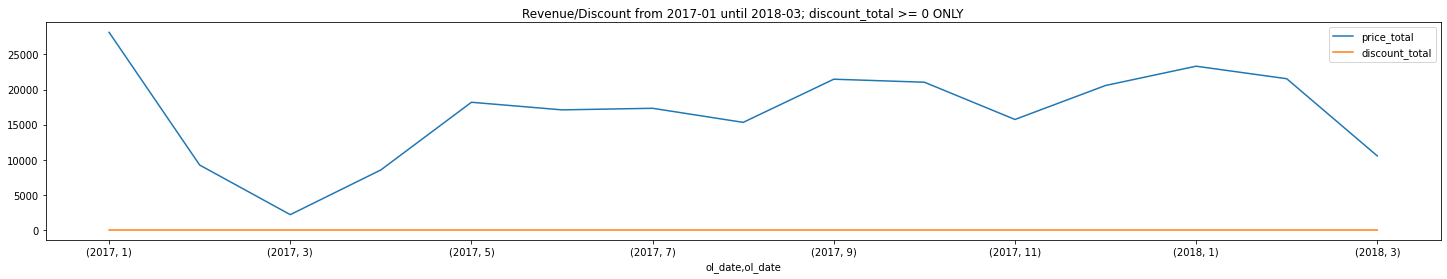

In [41]:
(
    ol_p_no_discounted
    ## records with discounts >=0 ONLY
    .loc[ol_p_no_discounted.discount_total >=0]
    .groupby(
        [
        ol_p_no_discounted['ol_date'].dt.year,
        ol_p_no_discounted['ol_date'].dt.month, 
        #ol_p['ol_date'].dt.month_name()
        ])['price_total', 'discount_total']
    .sum()
    .plot(figsize=(25, 4), x_compat=True, title='Revenue/Discount from 2017-01 until 2018-03; discount_total >= 0 ONLY')
);

10 most sold itemtype

In [80]:
top_sold_items =(
    ol_p
    .groupby('type')['product_quantity'].sum().sort_values(ascending= True).tail(15)
)

In [82]:
top_sold_items.sort_values(ascending= False)

type
11865403    4681
11935397    4395
1364        3916
11905404    3794
12655397    2847
5384        2591
12215397    2364
12585395    2082
1230        1942
1296        1744
1405        1330
1325        1293
1231        1228
12175397    1133
13835403    1028
Name: product_quantity, dtype: int64

10 most sold items type & category

In [84]:
(
ol_p
    .groupby('type')['product_quantity']
    .sum().sort_values(ascending= False)
    .head(10)
    
    )


type
11865403    4681
11935397    4395
1364        3916
11905404    3794
12655397    2847
5384        2591
12215397    2364
12585395    2082
1230        1942
1296        1744
Name: product_quantity, dtype: int64

In [85]:

(
    ol_p
    .groupby(ol_p['category']
    )['product_quantity']
    .sum().sort_values(ascending= False)
   

)

category
storage           15023
accessories       10557
apple_products     3086
headset            2591
monitors           1744
tablets            1330
server             1133
speaker             890
Name: product_quantity, dtype: int64

discount vs no discount -> sellings of top 9 categories


In [46]:
(
ol_p_no_discounted
      .groupby(ol_p['category']
    )['product_quantity']
    .sum().sort_values(ascending= False)
   
)

category
accessories       355
storage           309
apple_products    107
headset            73
server             67
speaker            27
monitors           15
tablets             1
Name: product_quantity, dtype: int64

In [47]:
(
ol_p_discounted
      .groupby(ol_p['category']
    )['product_quantity']
    .sum().sort_values(ascending= False)
 
)

category
storage           14243
accessories       10158
apple_products     2856
headset            2514
monitors           1584
tablets            1329
server             1043
speaker             858
Name: product_quantity, dtype: int64

Groupby dates month/year

#insert categorys! Consider days!


In [48]:
(
    ol_p
    .groupby([ol_p["ol_date"].dt.year, 
              ol_p["ol_date"].dt.month])["product_quantity"]
    .sum()
 )

ol_date  ol_date
2017     1          6906
         2          2923
         3           246
         4          2171
         5          2613
         6          2119
         7          4745
         8          3075
         9          2841
         10         4100
         11         9795
         12         6803
2018     1          6675
         2          4399
         3          1895
Name: product_quantity, dtype: int64

In [93]:
(
    ol_p_discounted
    .groupby([ol_p_discounted["ol_date"].dt.year, 
              ol_p_discounted["ol_date"].dt.month])["product_quantity"]
              #ol_p_discounted["ol_date"].dt.day])["product_quantity"]
    .sum()
 )

ol_date  ol_date
2017     1          6263
         2          2592
         3           202
         4          1966
         5          2246
         6          1879
         7          4388
         8          2827
         9          2569
         10         3830
         11         9551
         12         6488
2018     1          6262
         2          4017
         3          1742
Name: product_quantity, dtype: int64

In [50]:
(
    ol_p_no_discounted
    .groupby([ol_p_no_discounted["ol_date"].dt.year, 
              ol_p_no_discounted["ol_date"].dt.month])["product_quantity"]
    .sum()
 )

ol_date  ol_date
2017     1          425
         2          168
         3           29
         4          138
         5          242
         6          165
         7          263
         8          180
         9          222
         10         218
         11         190
         12         268
2018     1          351
         2          312
         3          150
Name: product_quantity, dtype: int64

In [51]:
(
    ol_p_no_discounted
    ## records with discounts >=0 ONLY
    .loc[ol_p_no_discounted.discount_total >=0]
    .groupby(
        [
        ol_p_no_discounted['ol_date'].dt.year,
        ol_p_no_discounted['ol_date'].dt.month, 
        #ol_p['ol_date'].dt.month_name()
        ])['price_total', 'discount_total']
    .sum()
)

price_total  discount_total
ol_date ol_date                             
2017    1           28142.03            0.59
        2            9247.28            0.15
        3            2185.79            0.05
        4            8553.80            0.01
        5           18186.05            0.16
        6           17104.76            0.10
        7           17329.11            0.12
        8           15324.41            0.74
        9           21469.19            0.40
        10          21041.61            0.10
        11          15737.51            0.20
        12          20574.92            0.37
2018    1           23320.15            0.13
        2           21539.24            0.02
        3           10546.54            0.05

In [52]:
(
    ol_p_discounted
    ## records with discounts >=0 ONLY
    .loc[ol_p_discounted.discount_total >=0]
    .groupby(
        [
        ol_p_discounted['ol_date'].dt.year,
        ol_p_discounted['ol_date'].dt.month, 
        #ol_p['ol_date'].dt.month_name()
        ])['price_total', 'discount_total']
    .sum())

price_total  discount_total
ol_date ol_date                             
2017    1          518453.39       153597.73
        2          277559.08        62694.00
        3           18818.80         4065.29
        4          207832.93        40099.11
        5          284837.53        55308.36
        6          239722.38        55004.63
        7          556404.05       141654.46
        8          346500.68        84808.51
        9          362556.23        75096.56
        10         525716.15       115383.42
        11        1504390.76       318674.50
        12         974651.31       170197.77
2018    1          842014.11       173855.66
        2          511452.45       124781.98
        3          211343.55        50171.84

#Which products included, interpretation ?
Include all in 1 DF!


In [53]:
discounted_quantity=(
    ol_p_discounted
    ## records with discounts >=0 ONLY
    .loc[ol_p_discounted.discount_total >=0]
    .groupby(
        [
        ol_p_discounted['ol_date'].dt.year,
        ol_p_discounted['ol_date'].dt.month, 
        #ol_p['ol_date'].dt.month_name()
        ])['price_total', 'discount_total', 'product_quantity']
    .sum()
)
discounted_quantity

price_total  discount_total  product_quantity
ol_date ol_date                                               
2017    1          518453.39       153597.73              6263
        2          277559.08        62694.00              2592
        3           18818.80         4065.29               202
        4          207832.93        40099.11              1966
        5          284837.53        55308.36              2246
        6          239722.38        55004.63              1879
        7          556404.05       141654.46              4388
        8          346500.68        84808.51              2827
        9          362556.23        75096.56              2569
        10         525716.15       115383.42              3830
        11        1504390.76       318674.50              9551
        12         974651.31       170197.77              6488
2018    1          842014.11       173855.66              6262
        2          511452.45       124781.98              4017
        3          211343.55        50171.84              1742

In [54]:
discounted_quantity.sum()

price_total         7382253.40
discount_total      1625393.82
product_quantity      56822.00
dtype: float64

In [55]:
no_discounted_quantity=(
    ol_p_no_discounted
    ## records with discounts >=0 ONLY
    .loc[ol_p_no_discounted.discount_total >=0]
    .groupby(
        [
        ol_p_no_discounted['ol_date'].dt.year,
        ol_p_no_discounted['ol_date'].dt.month, 
        #ol_p['ol_date'].dt.month_name()
        ])['price_total', 'discount_total', 'product_quantity']
    .sum()
)
no_discounted_quantity

price_total  discount_total  product_quantity
ol_date ol_date                                               
2017    1           28142.03            0.59               335
        2            9247.28            0.15               122
        3            2185.79            0.05                20
        4            8553.80            0.01                97
        5           18186.05            0.16               199
        6           17104.76            0.10               131
        7           17329.11            0.12               199
        8           15324.41            0.74               140
        9           21469.19            0.40               160
        10          21041.61            0.10               172
        11          15737.51            0.20               153
        12          20574.92            0.37               219
2018    1           23320.15            0.13               301
        2           21539.24            0.02               269
        3           10546.54            0.05               140

In [56]:
no_discounted_quantity.sum()

price_total         250302.39
discount_total           3.19
product_quantity      2657.00
dtype: float64

In [57]:
discounted_quantity['product_quantity']-no_discounted_quantity['product_quantity']

ol_date  ol_date
2017     1          5928
         2          2470
         3           182
         4          1869
         5          2047
         6          1748
         7          4189
         8          2687
         9          2409
         10         3658
         11         9398
         12         6269
2018     1          5961
         2          3748
         3          1602
Name: product_quantity, dtype: int64

In [58]:
dis_vs_no_dis=discounted_quantity['product_quantity']-no_discounted_quantity['product_quantity'].sum()
dis_vs_no_dis

ol_date  ol_date
2017     1          3606
         2           -65
         3         -2455
         4          -691
         5          -411
         6          -778
         7          1731
         8           170
         9           -88
         10         1173
         11         6894
         12         3831
2018     1          3605
         2          1360
         3          -915
Name: product_quantity, dtype: int64

In [59]:
dis_vs_no_dis_v2=discounted_quantity['product_quantity']-no_discounted_quantity['product_quantity']
dis_vs_no_dis_v2.sum()

54165

Apple
 AVG 

#Date 2017 Apple


In [97]:
ol_p.sample(15)

,id,id_order,product_quantity,sku,ol_price,ol_date,name,desc,p_price,in_stock,type,discount,discount_total,price_total,discount_cat,type_name,category
50377,1507126,467722,1,SYN0188,175.99,2017-12-20 11:53:07,Synology DS118 NAS server Mac and PC,1 bay NAS server with capacity for home use or...,175.99,0,12175397,0.00,0.00,175.99,no,server,server
44057,1614090,511629,1,WAC0246,69.99,2018-02-14 17:44:34,Wacom Bamboo Pen Sketch iPad / iPhone Black,digital pen with hard and soft tips triangular...,89.90,1,1229,19.91,19.91,69.99,yes,NaN,NaN
9409,1367691,407460,1,CRU0026-2,132.04,2017-10-02 16:47:07,Crucial memory Mac 16GB (2x8GB) SO-DIMM DDR3 1...,RAM 16GB (2x8GB) Mac mini (2011) iMac (2010/11...,163.98,1,1364,31.94,31.94,132.04,yes,RAM_mac_storage,storage
11898,1381300,414107,1,APP1216,139.99,2017-10-18 18:59:11,Apple Magic Trackpad 2,Apple Wireless Bluetooth Trackpad.,149.00,1,1387,9.01,9.01,139.99,yes,NaN,NaN
15970,1574172,496139,1,APP1919,55.99,2018-01-22 15:32:10,Apple Thunderbolt Adapter 3 / USB-C Thunderbol...,Thunderbolt adapter 3 / USB-C Thunderbolt 2 Ma...,59.00,1,1325,3.01,3.01,55.99,yes,NaN,NaN
41970,1296809,379123,1,LAC0229,499.99,2017-07-19 10:03:53,Lacie d2 Hard Drive 8TB Thunderbolt 3,8TB external hard drive designed to work 24x7 ...,529.00,0,11935397,29.01,29.01,499.99,yes,ext_HD_storage,storage
11569,1122134,300903,1,WAC0173,169.99,2017-01-02 19:31:54,Education - Wacom Intuos Creative Art Pen & To...,Graphic tablet with pen and touch digital tool...,199.99,0,1405,30.00,30.00,169.99,yes,tablets,tablets
36894,1326384,393491,1,HTE0014,94.99,2017-08-28 15:56:53,Hyperdrive DUO USB Hub 3-C Thunderbolt Silver,Hub Thunderbolt port 3 HDMI and USB-C ports an...,99.95,1,12585395,4.96,4.96,94.99,yes,adapter,accessories
49959,1580717,498539,2,OWC0244,221.58,2018-01-25 17:50:50,OWC Mercury Electra 6G SSD 500GB,SSD 500GB SATA HDD 7mm III for Mac.,266.99,0,12215397,45.41,90.82,443.16,yes,SSD_storage,storage
16823,1396152,421264,1,CRU0032,81.99,2017-11-02 21:26:54,Crucial Mac Memory 8GB DDR3 1333MHz SO-DIMM,8GB RAM Mac mini iMac (2010/11) and MacBook Pr...,81.99,1,1364,0.00,0.00,81.99,no,RAM_mac_storage,storage


Apple variable

In [98]:
ol_p_00 = ol_p.loc[ol_p['category'] == 'apple_products', :].drop(columns=['desc','in_stock'])

In [100]:
ol_p_00

,id,id_order,product_quantity,sku,ol_price,ol_date,name,p_price,type,discount,discount_total,price_total,discount_cat,type_name,category
4246,1120094,300035,1,APP1641,909.00,2017-01-01 22:05:04,Apple iPhone 7 Plus 32GB Silver,779.00,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products
4247,1124013,301786,1,APP1641,909.00,2017-01-03 16:39:55,Apple iPhone 7 Plus 32GB Silver,779.00,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products
4248,1160604,315265,1,APP1641,909.00,2017-01-27 08:10:34,Apple iPhone 7 Plus 32GB Silver,779.00,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products
4249,1266239,364727,1,APP1641,909.00,2017-06-12 10:43:59,Apple iPhone 7 Plus 32GB Silver,779.00,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products
4250,1369385,408234,1,APP1641,765.33,2017-10-04 10:09:07,Apple iPhone 7 Plus 32GB Silver,779.00,85651716,13.67,13.67,765.33,yes,iPhone_7+,apple_products
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54084,1636568,521601,1,AP20173,519.01,2018-03-05 12:05:15,Like new - Apple iPhone 32GB Rose Gold 7,639.00,85641716,119.99,119.99,519.01,yes,iPhone_7,apple_products
54087,1630019,518764,1,AP20302,390.33,2018-02-28 11:22:15,Like new - Apple iPhone 6 64GB Space Gray,749.00,21561716,358.67,358.67,390.33,yes,iPhone_6,apple_products
54091,1630115,518804,1,AP20453,729.00,2018-02-28 12:04:05,Like new - Apple iPhone 7 256GB Black Bright,990.33,85641716,261.33,261.33,729.00,yes,iPhone_7,apple_products
54272,1637871,522187,1,AP20265,759.00,2018-03-06 13:27:47,Like new - Apple iPhone 7 Plus 128GB Silver,889.00,85651716,130.00,130.00,759.00,yes,iPhone_7+,apple_products


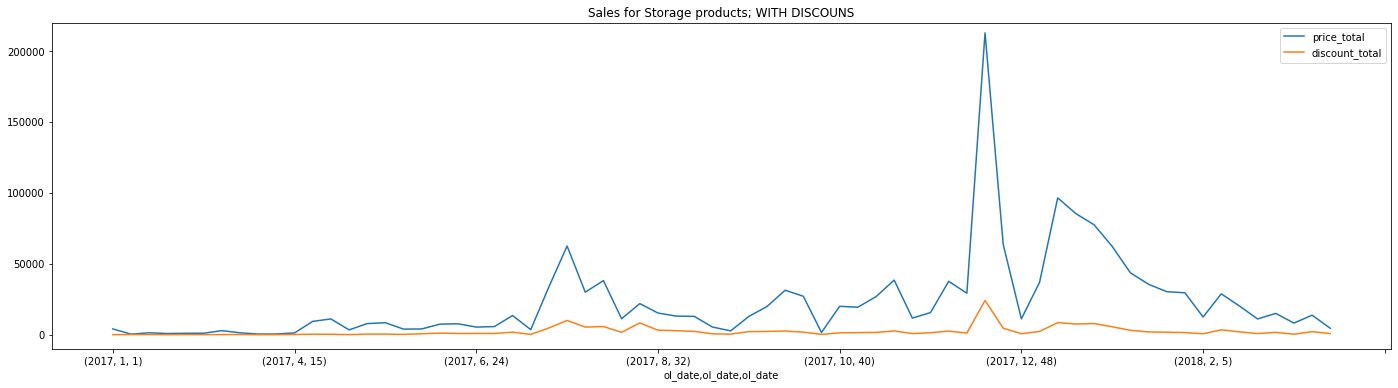

In [101]:
(
    ol_p_00
    #.loc[(ol_p_00['category']=='apple_products')&(ol_p_00['discount_cat']=='yes')|(ol_p_00['discount_cat']=='no')]
    .loc[(ol_p_00['category']=='apple_products')&(ol_p_00['discount_cat']=='yes')]
    .groupby([ol_p_00["ol_date"].dt.year,
              ol_p_00["ol_date"].dt.month,  
              ol_p_00["ol_date"].dt.week])[["price_total", "discount_total"]]
    .sum()
    .plot(figsize=(24, 6), title='Sales for Storage products; WITH DISCOUNS', ylim=[-10000, 220000])
); 

Apple in the year 2017

In [140]:
ol_p_00_2017 = ol_p_00.loc[ol_p_00["ol_date"].between("2017-01-01", "2017-12-31")]
ol_p_00_2017

,id,id_order,product_quantity,sku,ol_price,ol_date,name,p_price,type,discount,discount_total,price_total,discount_cat,type_name,category
4246,1120094,300035,1,APP1641,909.00,2017-01-01 22:05:04,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products
4247,1124013,301786,1,APP1641,909.00,2017-01-03 16:39:55,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products
4248,1160604,315265,1,APP1641,909.00,2017-01-27 08:10:34,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products
4249,1266239,364727,1,APP1641,909.00,2017-06-12 10:43:59,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products
4250,1369385,408234,1,APP1641,765.33,2017-10-04 10:09:07,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,13.67,13.67,765.33,yes,iPhone_7+,apple_products
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51754,1498638,463874,1,APP1782,293.00,2017-12-15 16:16:19,Apple Watch Series 1 42mm Aluminum Silver Case...,299.0,24895185,6.00,6.00,293.00,yes,apple_watch,apple_products
51755,1503505,466091,1,APP1782,293.00,2017-12-18 20:16:16,Apple Watch Series 1 42mm Aluminum Silver Case...,299.0,24895185,6.00,6.00,293.00,yes,apple_watch,apple_products
51795,1500123,464581,1,APP1988,872.00,2017-12-16 22:28:54,Apple iPhone 7 Plus (PRODUCT) Red 128GB,889.0,85651716,17.00,17.00,872.00,yes,iPhone_7+,apple_products
52746,1524100,475876,1,AP20444,799.00,2017-12-29 08:34:55,Like new - Apple iPhone 8 Plus 64GB Space Gray,919.0,113281716,120.00,120.00,799.00,yes,iPhone_8+,apple_products


mean of total price?

In [148]:
ol_p_00_2017['mean_total_price'] = (ol_p_00_2017['product_quantity'] * ol_p_00_2017['ol_price']).round(2).mean()
ol_p_00_2017['mean_total_price']

4246     557.454976
4247     557.454976
4248     557.454976
4249     557.454976
4250     557.454976
            ...    
51754    557.454976
51755    557.454976
51795    557.454976
52746    557.454976
52794    557.454976
Name: mean_total, Length: 2462, dtype: float64

In [150]:
ol_p_00_2017['mean_total_discount'] = (ol_p_00_2017['product_quantity'] * ol_p_00_2017['discount']).round(2).mean()
ol_p_00_2017['mean_total_discount']

4246     48.76608
4247     48.76608
4248     48.76608
4249     48.76608
4250     48.76608
           ...   
51754    48.76608
51755    48.76608
51795    48.76608
52746    48.76608
52794    48.76608
Name: mean_total_discount, Length: 2462, dtype: float64

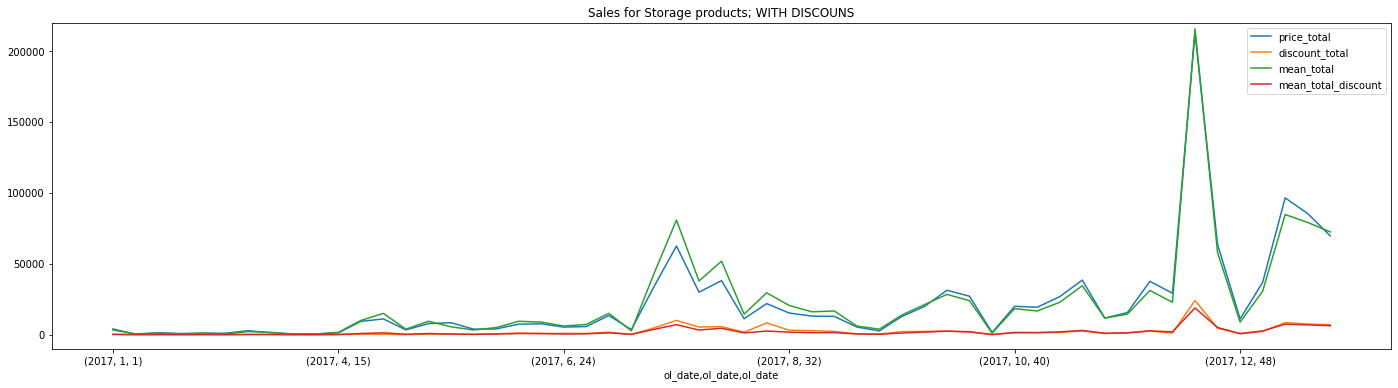

In [151]:
(
    ol_p_00_2017
    #.loc[(ol_p_00['category']=='apple_products')&(ol_p_00['discount_cat']=='yes')|(ol_p_00['discount_cat']=='no')]
    .loc[(ol_p_00_2017['category']=='apple_products')&(ol_p_00_2017['discount_cat']=='yes')]
    .groupby([ol_p_00_2017["ol_date"].dt.year,
              ol_p_00_2017["ol_date"].dt.month,  
              ol_p_00_2017["ol_date"].dt.week])[["price_total", "discount_total", 'mean_total', 'mean_total_discount']]
    .sum()
    .plot(figsize=(24, 6), title='Sales for Storage products; WITH DISCOUNS', ylim=[-10000, 220000])
); 

In [139]:
ol_p_00_2017_01_04 = ol_p_00.loc[ol_p_00["ol_date"].between("2017-01-01", "2017-04-30")]
ol_p_00_2017_01_04

,id,id_order,product_quantity,sku,ol_price,ol_date,name,p_price,type,discount,discount_total,price_total,discount_cat,type_name,category
4246,1120094,300035,1,APP1641,909.00,2017-01-01 22:05:04,Apple iPhone 7 Plus 32GB Silver,779.00,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products
4247,1124013,301786,1,APP1641,909.00,2017-01-03 16:39:55,Apple iPhone 7 Plus 32GB Silver,779.00,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products
4248,1160604,315265,1,APP1641,909.00,2017-01-27 08:10:34,Apple iPhone 7 Plus 32GB Silver,779.00,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products
4592,1120161,299466,2,APP1648,879.00,2017-01-01 22:38:40,Apple iPhone 7 128GB Black,749.00,85641716,-130.00,-260.00,1758.00,LTP,iPhone_7,apple_products
4593,1129652,302368,1,APP1648,879.00,2017-01-04 11:42:23,Apple iPhone 7 128GB Black,749.00,85641716,-130.00,-130.00,879.00,LTP,iPhone_7,apple_products
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36575,1236021,349969,1,APP1970,338.02,2017-04-26 13:17:24,Apple iPhone 32GB Space Gray,419.00,51601716,80.98,80.98,338.02,yes,iPhone_SE,apple_products
36576,1237445,350661,1,APP1970,409.00,2017-04-28 10:31:56,Apple iPhone 32GB Space Gray,419.00,51601716,10.00,10.00,409.00,yes,iPhone_SE,apple_products
37043,1234567,349330,1,APP1974,399.00,2017-04-24 18:37:12,Apple iPad Wi-Fi 32GB Silver,402.81,1714,3.81,3.81,399.00,yes,iPad,apple_products
37117,1234968,349278,1,APP1968,409.00,2017-04-25 10:36:15,Apple iPhone 32GB Gold,419.00,51601716,10.00,10.00,409.00,yes,iPhone_SE,apple_products


In [153]:
#ol_p_00_2017_01_04['mean_total_price'] = 
(ol_p_00_2017_01_04['product_quantity'] * ol_p_00_2017_01_04['ol_price']).round(2).sum()/len('ol_p_00_2017_01_04')
#ol_p_00_2017_01_04['mean_total_price']

4496.321111111111

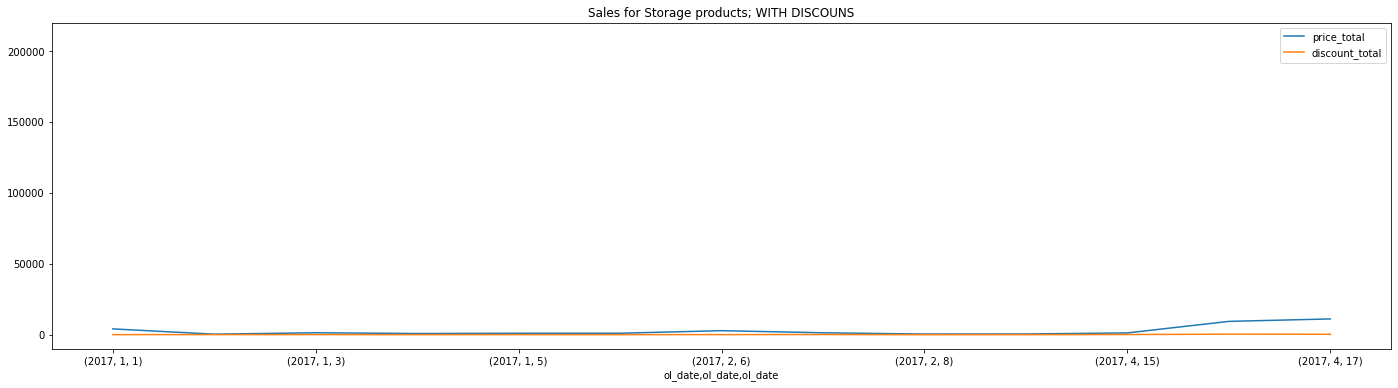

In [142]:
(
    ol_p_00_2017_01_04
    #.loc[(ol_p_00['category']=='apple_products')&(ol_p_00['discount_cat']=='yes')|(ol_p_00['discount_cat']=='no')]
    .loc[(ol_p_00_2017_01_04['category']=='apple_products')&(ol_p_00_2017_01_04['discount_cat']=='yes')]
    .groupby([ol_p_00_2017_01_04["ol_date"].dt.year,
              ol_p_00_2017_01_04["ol_date"].dt.month,  
              ol_p_00_2017_01_04["ol_date"].dt.week])[["price_total", "discount_total"]]
    .sum()
    .plot(figsize=(24, 6), title='Sales for Storage products; WITH DISCOUNS', ylim=[-10000, 220000])
); 

In [138]:
ol_p_00_2017_05_08 = ol_p_00.loc[ol_p_00["ol_date"].between("2017-05-01", "2017-08-31")]
ol_p_00_2017_05_08

,id,id_order,product_quantity,sku,ol_price,ol_date,name,p_price,type,discount,discount_total,price_total,discount_cat,type_name,category
4249,1266239,364727,1,APP1641,909.00,2017-06-12 10:43:59,Apple iPhone 7 Plus 32GB Silver,779.00,85651716,-130.0,-130.0,909.00,LTP,iPhone_7+,apple_products
4596,1255726,359470,1,APP1648,839.00,2017-05-26 17:41:15,Apple iPhone 7 128GB Black,749.00,85641716,-90.0,-90.0,839.00,LTP,iPhone_7,apple_products
4597,1268715,365919,1,APP1648,879.00,2017-06-15 13:22:39,Apple iPhone 7 128GB Black,749.00,85641716,-130.0,-130.0,879.00,LTP,iPhone_7,apple_products
4598,1280788,371839,1,APP1648,826.00,2017-07-03 12:35:53,Apple iPhone 7 128GB Black,749.00,85641716,-77.0,-77.0,826.00,LTP,iPhone_7,apple_products
4599,1282482,372655,1,APP1648,826.00,2017-07-04 20:20:06,Apple iPhone 7 128GB Black,749.00,85641716,-77.0,-77.0,826.00,LTP,iPhone_7,apple_products
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43960,1312246,386669,1,APP2466,499.00,2017-08-06 14:59:24,The 1st Gen. 42mm Apple Watch Stainless Steel ...,1269.00,24895185,770.0,770.0,499.00,yes,apple_watch,apple_products
44229,1314781,387882,1,APP2455,369.00,2017-08-09 14:11:08,Apple Watch the 1st Gen. 42mm Stainless Steel ...,819.00,24895185,450.0,450.0,369.00,yes,apple_watch,apple_products
44230,1318251,389575,1,APP2455,369.00,2017-08-15 00:58:03,Apple Watch the 1st Gen. 42mm Stainless Steel ...,819.00,24895185,450.0,450.0,369.00,yes,apple_watch,apple_products
44485,1320480,390651,1,APP1984,539.81,2017-08-19 10:20:36,Apple iPad Wi-Fi + Cellular 32GB Space Gray,562.81,1714,23.0,23.0,539.81,yes,iPad,apple_products


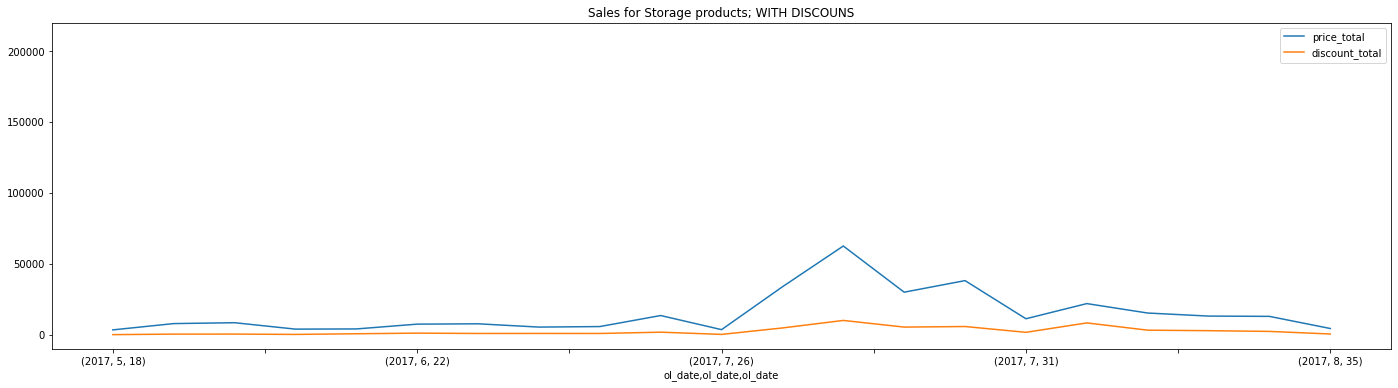

In [143]:
(
    ol_p_00_2017_05_08
    #.loc[(ol_p_00['category']=='apple_products')&(ol_p_00['discount_cat']=='yes')|(ol_p_00['discount_cat']=='no')]
    .loc[(ol_p_00_2017_05_08['category']=='apple_products')&(ol_p_00_2017_05_08['discount_cat']=='yes')]
    .groupby([ol_p_00_2017_05_08["ol_date"].dt.year,
              ol_p_00_2017_05_08["ol_date"].dt.month,  
              ol_p_00_2017_05_08["ol_date"].dt.week])[["price_total", "discount_total"]]
    .sum()
    .plot(figsize=(24, 6), title='Sales for Storage products; WITH DISCOUNS', ylim=[-10000, 220000])
); 

In [137]:
ol_p_00_2017_09_12 = ol_p_00.loc[ol_p_00["ol_date"].between("2017-09-01", "2017-12-31")]
ol_p_00_2017_09_12

,id,id_order,product_quantity,sku,ol_price,ol_date,name,p_price,type,discount,discount_total,price_total,discount_cat,type_name,category
4250,1369385,408234,1,APP1641,765.33,2017-10-04 10:09:07,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,13.67,13.67,765.33,yes,iPhone_7+,apple_products
4251,1371714,409412,1,APP1641,765.33,2017-10-06 13:13:56,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,13.67,13.67,765.33,yes,iPhone_7+,apple_products
4252,1456843,447751,1,APP1641,748.75,2017-11-27 11:48:28,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,30.25,30.25,748.75,yes,iPhone_7+,apple_products
4253,1482892,457584,1,APP1641,764.00,2017-12-08 12:02:24,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,15.00,15.00,764.00,yes,iPhone_7+,apple_products
4602,1350510,399085,1,APP1648,840.33,2017-09-12 09:58:32,Apple iPhone 7 128GB Black,749.0,85641716,-91.33,-91.33,840.33,LTP,iPhone_7,apple_products
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51754,1498638,463874,1,APP1782,293.00,2017-12-15 16:16:19,Apple Watch Series 1 42mm Aluminum Silver Case...,299.0,24895185,6.00,6.00,293.00,yes,apple_watch,apple_products
51755,1503505,466091,1,APP1782,293.00,2017-12-18 20:16:16,Apple Watch Series 1 42mm Aluminum Silver Case...,299.0,24895185,6.00,6.00,293.00,yes,apple_watch,apple_products
51795,1500123,464581,1,APP1988,872.00,2017-12-16 22:28:54,Apple iPhone 7 Plus (PRODUCT) Red 128GB,889.0,85651716,17.00,17.00,872.00,yes,iPhone_7+,apple_products
52746,1524100,475876,1,AP20444,799.00,2017-12-29 08:34:55,Like new - Apple iPhone 8 Plus 64GB Space Gray,919.0,113281716,120.00,120.00,799.00,yes,iPhone_8+,apple_products


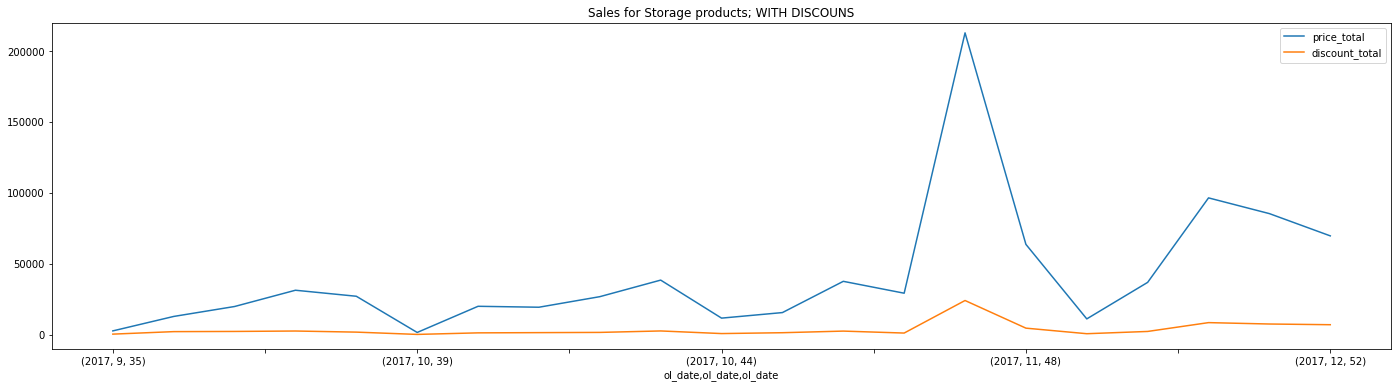

In [144]:
(
    ol_p_00_2017_09_12
    #.loc[(ol_p_00['category']=='apple_products')&(ol_p_00['discount_cat']=='yes')|(ol_p_00['discount_cat']=='no')]
    .loc[(ol_p_00_2017_09_12['category']=='apple_products')&(ol_p_00_2017_09_12['discount_cat']=='yes')]
    .groupby([ol_p_00_2017_09_12["ol_date"].dt.year,
              ol_p_00_2017_09_12["ol_date"].dt.month,  
              ol_p_00_2017_09_12["ol_date"].dt.week])[["price_total", "discount_total"]]
    .sum()
    .plot(figsize=(24, 6), title='Sales for Storage products; WITH DISCOUNS', ylim=[-10000, 220000])
); 

In [136]:
## calclulating and a adding new colum 'discount_total'
#ol_p['discount_total'] = 
(ol_p_00_2017_09_12['product_quantity'] * ol_p_00_2017_09_12['discount']).round(2)

## calclulating and a adding new colum 'price_total'
#ol_p['price_total'] = 
(ol_p_00_2017_09_12['product_quantity'] * ol_p_00_2017_09_12['ol_price']).round(2)

4250    765.33
4251    765.33
4252    748.75
4253    764.00
4602    840.33
dtype: float64

In [135]:
ol_p_00_2017_09_12["price_total"].mean()

776.7479999999999

Quartes sales| Increase of order but decrease of revenue?

In [154]:
ol_p_00_2017['price_total'] = (ol_p['product_quantity'] * ol_p['ol_price']).round(2)
ol_p_00_2017

,id,id_order,product_quantity,sku,ol_price,ol_date,name,p_price,type,discount,discount_total,price_total,discount_cat,type_name,category,mean_total,mean_total_discount
4246,1120094,300035,1,APP1641,909.00,2017-01-01 22:05:04,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products,557.454976,48.76608
4247,1124013,301786,1,APP1641,909.00,2017-01-03 16:39:55,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products,557.454976,48.76608
4248,1160604,315265,1,APP1641,909.00,2017-01-27 08:10:34,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products,557.454976,48.76608
4249,1266239,364727,1,APP1641,909.00,2017-06-12 10:43:59,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,-130.00,-130.00,909.00,LTP,iPhone_7+,apple_products,557.454976,48.76608
4250,1369385,408234,1,APP1641,765.33,2017-10-04 10:09:07,Apple iPhone 7 Plus 32GB Silver,779.0,85651716,13.67,13.67,765.33,yes,iPhone_7+,apple_products,557.454976,48.76608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51754,1498638,463874,1,APP1782,293.00,2017-12-15 16:16:19,Apple Watch Series 1 42mm Aluminum Silver Case...,299.0,24895185,6.00,6.00,293.00,yes,apple_watch,apple_products,557.454976,48.76608
51755,1503505,466091,1,APP1782,293.00,2017-12-18 20:16:16,Apple Watch Series 1 42mm Aluminum Silver Case...,299.0,24895185,6.00,6.00,293.00,yes,apple_watch,apple_products,557.454976,48.76608
51795,1500123,464581,1,APP1988,872.00,2017-12-16 22:28:54,Apple iPhone 7 Plus (PRODUCT) Red 128GB,889.0,85651716,17.00,17.00,872.00,yes,iPhone_7+,apple_products,557.454976,48.76608
52746,1524100,475876,1,AP20444,799.00,2017-12-29 08:34:55,Like new - Apple iPhone 8 Plus 64GB Space Gray,919.0,113281716,120.00,120.00,799.00,yes,iPhone_8+,apple_products,557.454976,48.76608


In [157]:
(
    ol_p_00_2017
    .groupby([ol_p_00_2017["ol_date"].dt.year, 
              ol_p_00_2017["ol_date"].dt.month])["product_quantity"]
    .sum()
 )

ol_date  ol_date
2017     1           53
         2           27
         3            1
         4           59
         5           76
         6          114
         7          447
         8          182
         9          191
         10         223
         11         641
         12         523
Name: product_quantity, dtype: int64

In [162]:
(
ol_p_00_2017
      .groupby(ol_p_00_2017['category']
    )['product_quantity']
    .sum().sort_values(ascending= False)
 
)

category
apple_products    2537
Name: product_quantity, dtype: int64

In [ ]:
ol_p_00_2017_01_04

In [ ]:
ol_p_00_2017_05_08

In [ ]:
ol_p_00_2017_09_12

In [174]:
ol_p

,id,id_order,product_quantity,sku,ol_price,ol_date,name,desc,p_price,in_stock,type,discount,discount_total,price_total,discount_cat,type_name,category
0,1119116,299545,1,OWC0100,47.49,2017-01-01 01:46:16,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,1,12755395,13.50,13.50,47.49,yes,NaN,NaN
1,1120182,299404,1,OWC0100,47.49,2017-01-01 22:50:39,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,1,12755395,13.50,13.50,47.49,yes,NaN,NaN
2,1121550,300650,1,OWC0100,49.99,2017-01-02 15:31:09,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,1,12755395,11.00,11.00,49.99,yes,NaN,NaN
3,1121801,300760,1,OWC0100,49.99,2017-01-02 17:20:31,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,1,12755395,11.00,11.00,49.99,yes,NaN,NaN
4,1124334,301975,1,OWC0100,49.99,2017-01-03 20:04:54,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,1,12755395,11.00,11.00,49.99,yes,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54319,1647425,526066,1,WAC0254,83.99,2018-03-12 17:45:42,Education - Wacom Intuos Graphics Tablet S Blu...,small-edge graphics tablet with Bluetooth inte...,99.00,1,1405,15.01,15.01,83.99,yes,tablets,tablets
54320,1647495,526093,1,WAC0252,83.99,2018-03-12 18:32:29,Education - Wacom Intuos Graphics Tablet S Blu...,small-edge graphics tablet with Bluetooth inte...,99.00,1,1405,15.01,15.01,83.99,yes,tablets,tablets
54321,1648399,526440,1,PAC2235,878.18,2018-03-13 15:08:27,Synology DS218 + NAS Server | 6GB RAM | 16TB (...,NAS storage server integrated with special foc...,1124.98,1,12175397,246.80,246.80,878.18,yes,server,server
54322,1648457,526512,1,DLK0044-A,84.32,2018-03-13 16:19:18,Open - D-Link DCS-5020L wireless surveillance ...,Reconditioned surveillance camera with Wi-Fi r...,139.99,0,9094,55.67,55.67,84.32,yes,NaN,NaN


Order count & revenue over quarters

In [176]:
first_quarter = (ol_p.loc[ol_p['ol_date'].between("2017-01-01", "2017-03-01")])
first_quarter_orders = first_quarter['id_order'].count()
first_quarter_orders

8664

In [ ]:
## calclulating and a adding new colum 'discount_total'
#ol_p['discount_total'] = 
(ol_p_00_2017_09_12['product_quantity'] * ol_p_00_2017_09_12['discount']).round(2)

## calclulating and a adding new colum 'price_total'
#ol_p['price_total'] = 
(ol_p_00_2017_09_12['product_quantity'] * ol_p_00_2017_09_12['ol_price']).round(2)